# Complicance and Other Checks
This notebook ensures that the `UncertaintyForest` estimator is `sklearn`-compliant, and consistent with Richard's code. These checks will be incorporated into tests later.

In [18]:
import numpy as np
import matplotlib.pyplot as plt

from uncertainty_forest.uncertainty_forest import UncertaintyForest
from scipy.stats import norm
from scipy.integrate import quad

# Manual forest generation.
from sklearn.ensemble.forest import _generate_unsampled_indices
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
import math

## Check that Conditional Entropy estimate is consistent with Richard's code.

In [14]:
def generate_data(n, d, mu = 1):
    n_1 = np.random.binomial(n, .5) # number of class 1
    mean = np.zeros(d)
    mean[0] = mu
    X_1 = np.random.multivariate_normal(mean, np.eye(d), n_1)
    
    X = np.concatenate((X_1, np.random.multivariate_normal(-mean, np.eye(d), n - n_1)))
    y = np.concatenate((np.repeat(1, n_1), np.repeat(-1, n - n_1)))
  
    return X, y

In [26]:
def true_cond_entropy(mu, base = 2.0):
    def func(x):
        p = 0.5 * norm.pdf(x, mu, 1) + 0.5 * norm.pdf(x, -mu, 1)
        return -p * np.log(p) / np.log(base)
    
    H_X = quad(func, -20, 20)
    H_XY = 0.5*(1.0 + np.log(2 * np.pi)) / np.log(base)
    H_Y = np.log(2.0) / np.log(base)
    # I_XY = H_X - H_XY = H_Y - H_YX
    return H_Y - H_X[0] + H_XY

In [6]:
def cef_estimate(X, y, n_estimators = 200, max_samples = .32, bootstrap = True, depth = 30, min_samples_leaf = 1, max_features = 1.):
    model = BaggingClassifier(DecisionTreeClassifier(max_depth = depth, min_samples_leaf = min_samples_leaf, max_features = math.ceil(int(math.sqrt(X.shape[1])))),
                              n_estimators = n_estimators,
                              max_samples= max_samples,
                              bootstrap = bootstrap)
    model.fit(X, y)
    class_counts = np.zeros((X.shape[0], model.n_classes_))
    for tree in model:
        # get out of bag indicies
        unsampled_indices = _generate_unsampled_indices(tree.random_state, len(X))

        total_unsampled = len(unsampled_indices)
        np.random.shuffle(unsampled_indices)
        prob_indices, eval_indices = unsampled_indices[:total_unsampled//2], unsampled_indices[total_unsampled//2:]
        # get all node counts
        node_counts = tree.tree_.n_node_samples
        # get probs for eval samples
        posterior_class_counts = np.zeros((len(node_counts), model.n_classes_))
        for prob_index in prob_indices:
            posterior_class_counts[tree.apply(X[prob_index].reshape(1, -1)).item(), y[prob_index]] += 1
        row_sums = posterior_class_counts.sum(axis=1)
        row_sums[row_sums == 0] = 1
        class_probs = (posterior_class_counts/row_sums[:, None])

        where_0 = np.argwhere(class_probs == 0)
        for elem in where_0:
            class_probs[elem[0], elem[1]] = 1/(2*row_sums[elem[0], None])
        where_1 = np.argwhere(class_probs == 1)
        for elem in where_1:
            class_probs[elem[0], elem[1]] = 1 - 1/(2*row_sums[elem[0], None])

        class_probs.tolist()
        partition_counts = np.asarray([node_counts[x] for x in tree.apply(X[eval_indices])])
        # get probability for out of bag samples
        eval_class_probs = [class_probs[x] for x in tree.apply(X[eval_indices])]
        eval_class_probs = np.array(eval_class_probs)
        # find total elements for out of bag samples
        elems = np.multiply(eval_class_probs, partition_counts[:, np.newaxis])
        # store counts for each x (repeat fhis for each tree)
        class_counts[eval_indices] += elems
    # calculate p(y|X = x) for all x's
    probs = class_counts/class_counts.sum(axis = 1, keepdims = True)
    entropies = -np.sum(np.log(probs)*probs, axis = 1)
    # convert nan to 0
    entropies = np.nan_to_num(entropies)
    return np.mean(entropies)

np.warnings.filterwarnings('ignore')

In [ ]:
mu = 1
d = 1
sample_sizes = [100, 200, 300, 400]
num_trials = 5

In [9]:
richard = np.zeros(len(sample_sizes))
ronak = np.zeros(len(sample_sizes))

for i, n in enumerate(sample_sizes):
    print("Sample size:", n)
    for t in range(num_trials):
        X, y = generate_data(n, d, mu = mu)
        richard[i] += cef_estimate(X, y, n, .32, depth = 30)

        uf = UncertaintyForest(n_estimators = 200)
        uf.fit(X, y)
        ronak[i] += uf.estimate_cond_entropy()
    richard[i] /= num_trials
    ronak[i] /= num_trials

(-0.05, 1.05)

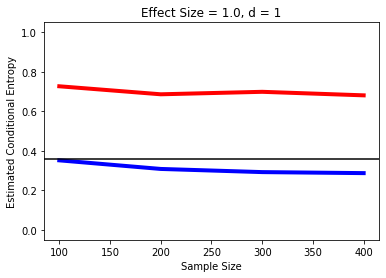

In [29]:
plt.plot(sample_sizes,
         ronak.flatten(), 
         label = 'Ronak', 
         linewidth = 4, 
         color = 'red')
plt.plot(sample_sizes,
         richard.flatten(), 
         label = 'Richard', 
         linewidth = 4, 
         color = 'blue')

truth = true_cond_entropy(mu, base = np.exp(1))
plt.axhline(y = truth, linestyle = '-', color = "black", label = "Truth")

plt.xlabel("Sample Size")
plt.ylabel("Estimated Conditional Entropy")
plt.title("Effect Size = %.1f, d = %d" % (mu, d))
plt.ylim(ymin = -0.05, ymax = 1.05)

In [28]:
print(true_cond_entropy(mu, base = np.exp(1)))
print(np.log(np.exp(1)))

0.3563163602131145
1.0
